In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad
from jax import jit, lax
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from cartpolejax import JAXCartPole
from cartpolejax import loss as jax_loss

In [2]:
def feature_extension(X):
    X = np.array(X)

    if X.ndim == 2:
        if X.shape[1] == 5:
            # Matrix input: N x 4
            X_theta = X[:, 2]
            X_sin = np.sin(X_theta)
            X_cos = np.cos(X_theta)
            return np.column_stack([X[:, 0], X[:, 1], X_sin, X_cos, X[:, 3], X[:, 4]])
        elif X.shape[1] == 6:
            print('feature already extended')
            return X
    elif X.ndim == 1:
        if X.shape[0] == 5:
            x0, x1, theta, x3, x4 = X
            return np.array([x0, x1, np.sin(theta), np.cos(theta), x3, x4])
        elif X.shape[0] == 6:
            print('feature already extended')
            return X

    raise ValueError(f'feature_extension FAILED: unexpected input shape {X.shape}')

In [3]:
print(feature_extension([[1, 0, 2, 4, 7], [2, 0, 2, 5, 8]]))

[[ 1.          0.          0.90929743 -0.41614684  4.          7.        ]
 [ 2.          0.          0.90929743 -0.41614684  5.          8.        ]]


In [4]:
X_raw = np.load('X_dt0p010_N8000_act_notanh_obsnoise.npy')
Y_raw = np.load('Y_dt0p010_N8000_act_notanh_obsnoise.npy')

print(X_raw[0])
print(Y_raw[0])

[ -4.60134735 -17.60932216   2.3264818  -22.7409456    0.2258428 ]
[-0.1701707   0.60344768 -0.2138252   1.45410594]


In [5]:
print(len(X_raw))

8000


### Nonlinear Model

In [ ]:
# kernel
X_ext = feature_extension(X_raw)
sigma = np.std(X_ext, axis=0) # initial value for sigma

def kernel(X, Xp, sigma=sigma):
    X_ext = feature_extension(X)
    Xp_ext = feature_extension(Xp)
    
    dist2 = ((X_ext - Xp_ext) / sigma) ** 2
    return np.exp(-0.5 * np.sum(dist2, axis=1))

In [7]:
# nonlinear model
def nonlinear_model(state, alpha, sigma=sigma):
    pred = kernel(state[np.newaxis], kernel_centers, sigma=sigma) @ alpha
    return pred.squeeze()

#### Effect of Changing the Number of Basis Functions

In [8]:
num_centers = [40, 80, 160, 320, 640, 1280]
lambdas = np.logspace(-10, -1, num=10)

labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
n_vars = len(labels)

In [9]:
total_mses = []
best_alphas = []
Y_preds = []

for cur, M in enumerate(num_centers):
    print(f"Processing M = {M}")
    kernel_centers = X_raw[:M]

    # Build Kmn
    N = len(X_raw)
    Kmn = np.zeros((M, N))
    for i, kernel_center in enumerate(kernel_centers):
        Kmn[i] = kernel(X_raw, kernel_center[np.newaxis], sigma=sigma)

    # Build Kmm
    Kmm = np.zeros((M, M))
    for i, kernel_center in enumerate(kernel_centers):
        Kmm[i] = kernel(kernel_centers, kernel_center[np.newaxis], sigma=sigma)

    alphas = []
    for l in lambdas:
        A = Kmn @ Kmn.T + l * Kmm
        b = Kmn @ Y_raw
        alphas.append(np.linalg.lstsq(A, b, rcond=None)[0])

    # Choose best alpha
    alpha_errors = []
    for idx, alpha in enumerate(alphas):
        Y_pred = np.array([nonlinear_model(x, alpha) for x in X_raw])
        mse_per_variable = np.mean((Y_raw - Y_pred) ** 2, axis=0)
        total_mse = np.sum(mse_per_variable)
        alpha_errors.append((idx, alpha, total_mse))

    best_idx, best_alpha, best_error = min(alpha_errors, key=lambda x: x[2])
    total_mses.append(best_error)
    best_alphas.append(best_alpha)

    Y_pred = np.array([nonlinear_model(x, best_alpha) for x in X_raw])
    Y_preds.append(Y_pred)
print('finished')

Processing M = 40
Processing M = 80
Processing M = 160
Processing M = 320
Processing M = 640
Processing M = 1280
finished


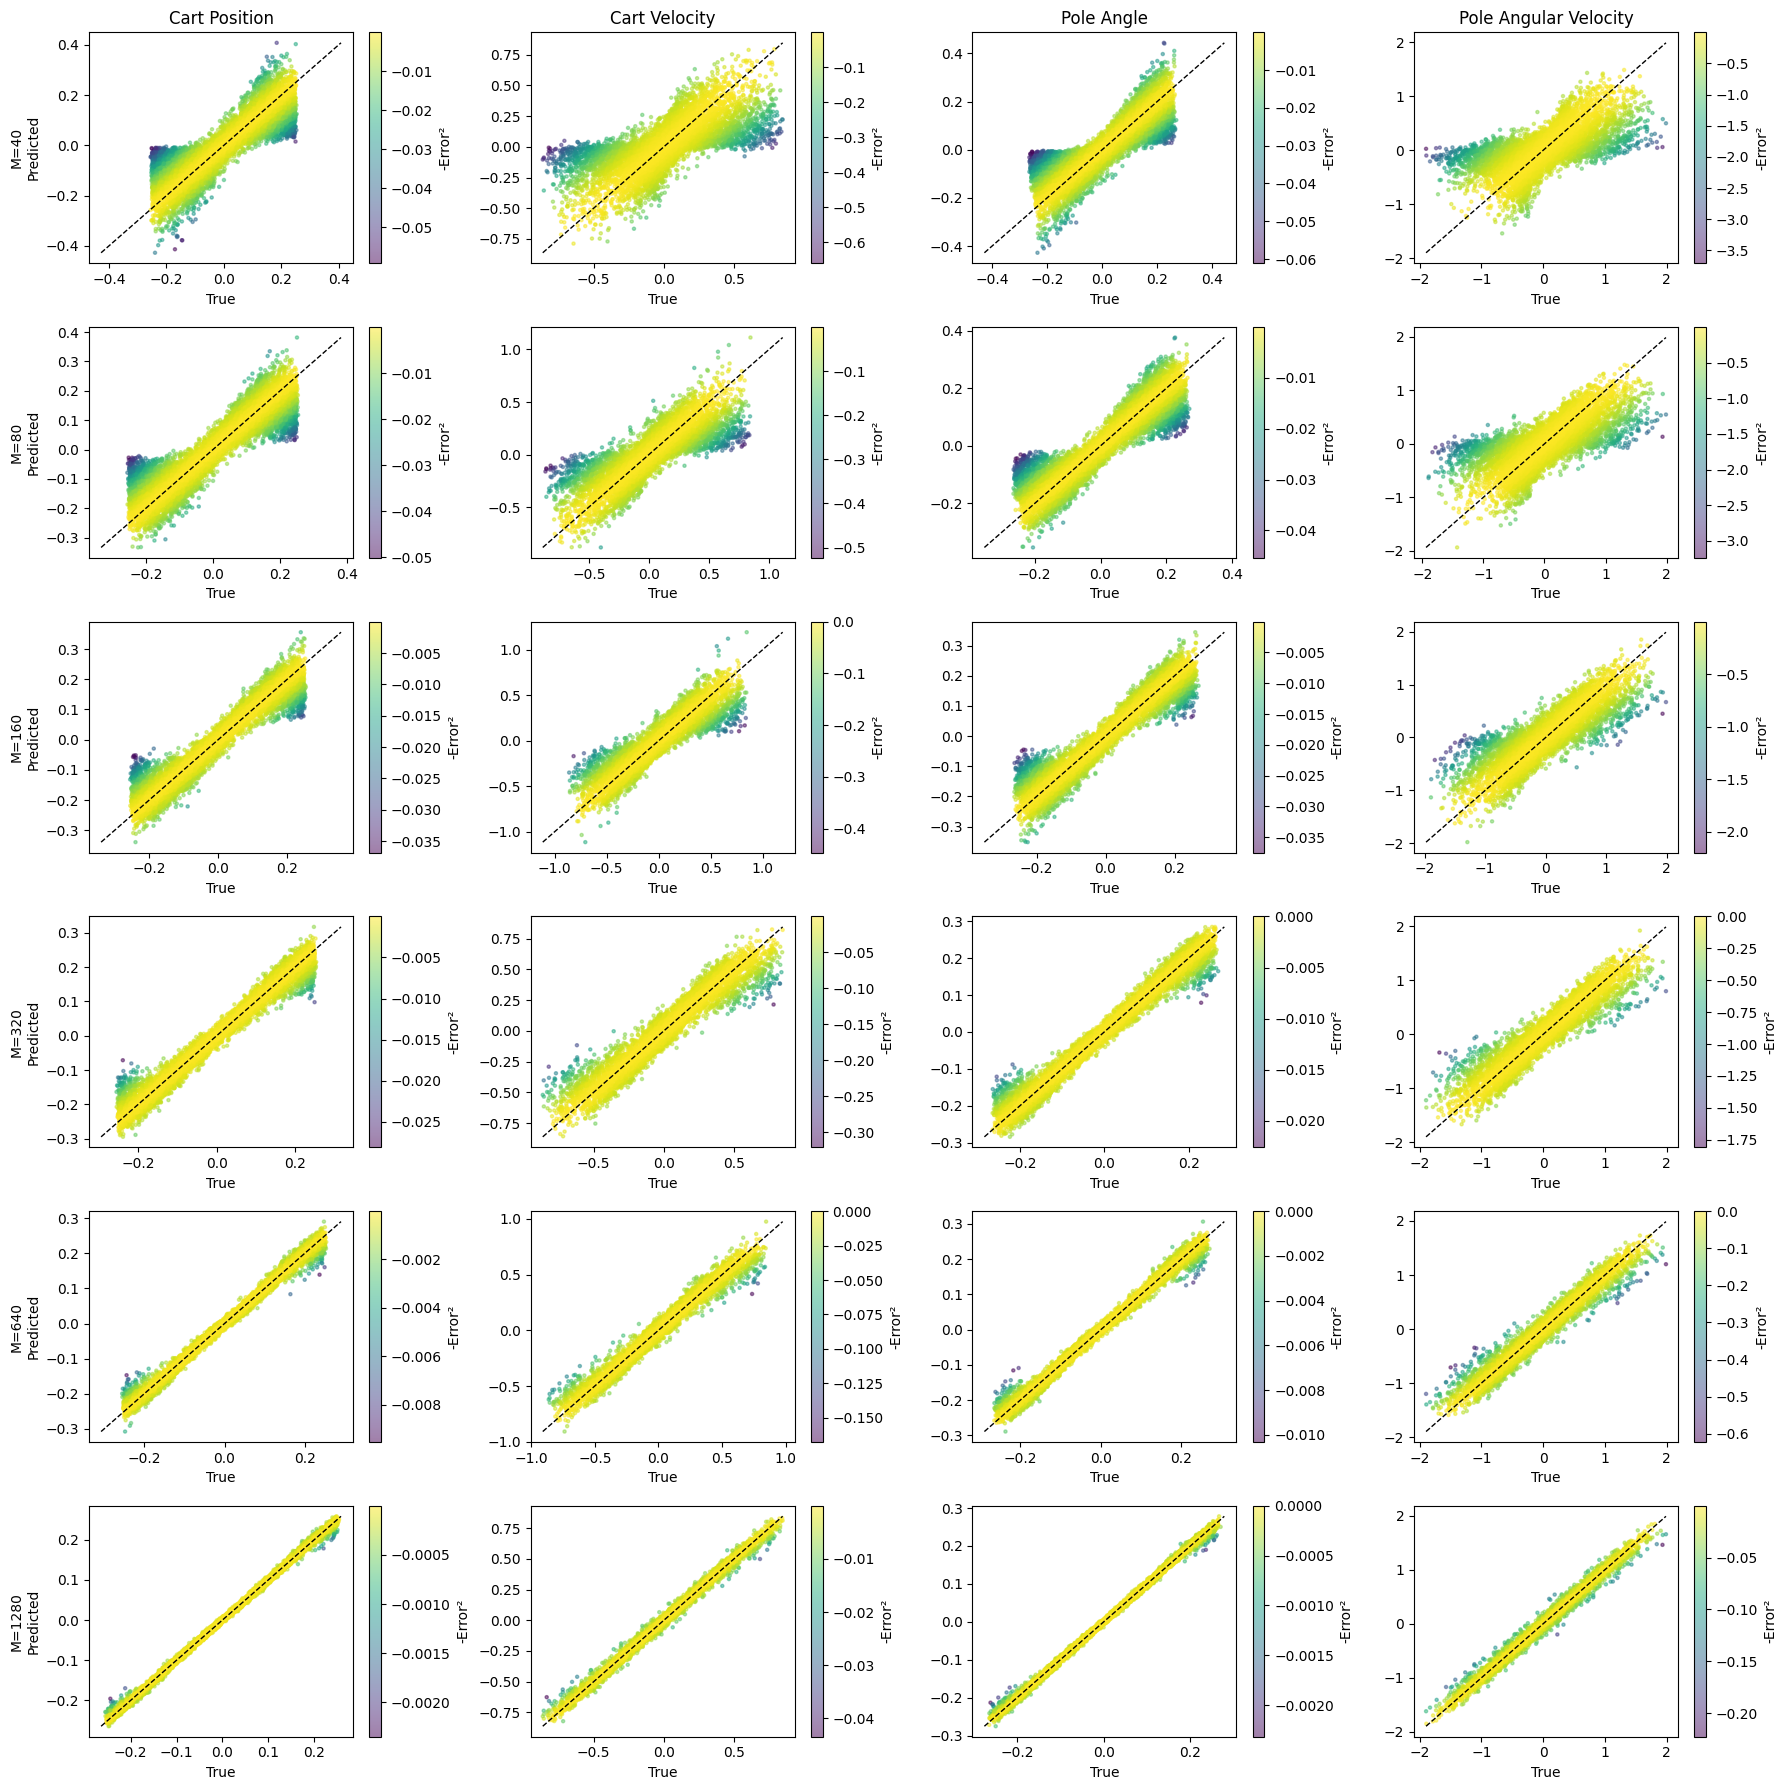

In [10]:
# plot
n_rows = len(num_centers)
plt.figure(figsize=(n_vars * 4.5, n_rows * 3))

for row, (M, Y_pred) in enumerate(zip(num_centers, Y_preds)):
    for col in range(n_vars):
        true_vals = Y_raw[:, col]
        pred_vals = Y_pred[:, col]
        error = -1 * (np.abs(pred_vals - true_vals) ** 2)

        idx = row * n_vars + col + 1
        ax = plt.subplot(n_rows, n_vars, idx)
        sc = ax.scatter(true_vals, pred_vals, c=error, s=5, cmap='viridis', alpha=0.5)

        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

        if row == 0:
            ax.set_title(labels[col])
        if col == 0:
            ax.set_ylabel(f'M={M}\nPredicted')
        ax.set_xlabel('True')
        plt.colorbar(sc, ax=ax, label='-Error²')

plt.tight_layout()
# plt.savefig('compare_all_Ms_with_individual_colorbars.png')
plt.show()


In [11]:
print(total_mses)

[np.float64(0.23583110534583282), np.float64(0.18758095292233412), np.float64(0.10875478731306659), np.float64(0.047872273446656344), np.float64(0.019932971725459454), np.float64(0.005651270415157873)]


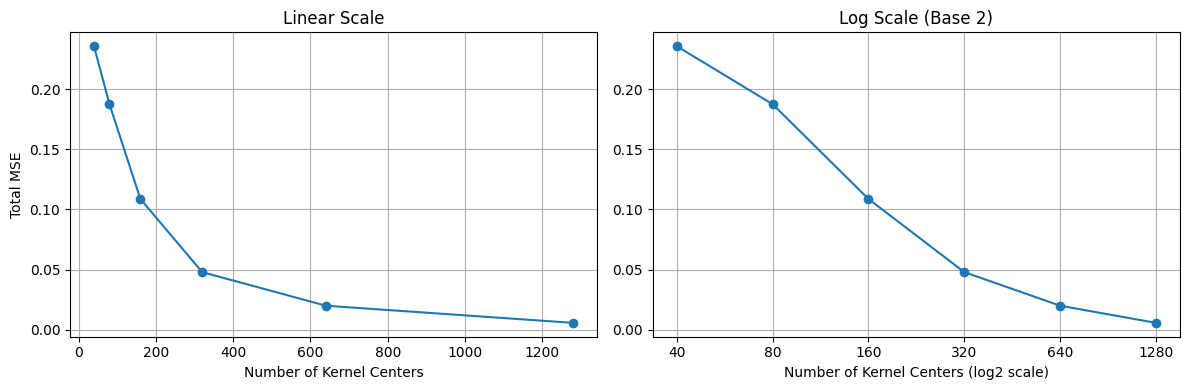

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# linear scale plot
axes[0].plot(num_centers, total_mses, marker='o', linestyle='-')
axes[0].set_title('Linear Scale')
axes[0].set_xlabel('Number of Kernel Centers')
axes[0].set_ylabel('Total MSE')
axes[0].grid(True)

# log scale plot (base 2)
axes[1].plot(num_centers, total_mses, marker='o', linestyle='-')
axes[1].set_xscale('log', base=2)
axes[1].set_xticks(num_centers)
axes[1].set_xticklabels([str(n) for n in num_centers])
axes[1].set_title('Log Scale (Base 2)')
axes[1].set_xlabel('Number of Kernel Centers (log2 scale)')
axes[1].grid(True, which='both')

plt.tight_layout()
plt.show()

In [13]:
# plot 2D slices

num_scan = 100

# deterministic
cart_pos = 0
cart_vel = -7.644
pole_ang = 2.744
pole_vel = 7.176
# [cart_pos, cart_vel, pole_angle, pole_angular_vel]
random_state = [cart_pos, cart_vel, pole_ang, pole_vel]
action = 2.104

cart_pos_scan = np.linspace(-5, 5, num_scan)
cart_vel_scan = np.linspace(-10, 10, num_scan)
pole_ang_scan = np.linspace(-np.pi, np.pi, num_scan)
pole_vel_scan = np.linspace(-15, 15, num_scan)
action_scan = np.linspace(-15, 15, num_scan)
scan = [cart_pos_scan, cart_vel_scan, pole_ang_scan, pole_vel_scan, action_scan]

In [14]:
env = CartPole(visual=False)
env.sim_steps = 1         # number of Euler integration steps to perform in one go
env.delta_time = 0.01

In [23]:
cart_pos = 0
cart_vel = -7.644
pole_ang = 2.744
pole_vel = 7.176
# [cart_pos, cart_vel, pole_angle, pole_angular_vel]
random_state = [cart_pos, cart_vel, pole_ang, pole_vel]
action = 2.104

In [24]:
# best nonlinear model
best_idx = -1
M = num_centers[best_idx]
kernel_centers = X_raw[:M]  # data generated randomly, choose first M points will do
# print(kernel_centers)

[  0.          -7.644       -3.14159265 -15.           2.104     ]
[-0.07504505  0.04019291 -0.14678566  0.14439625]
[-0.07504505 -0.07506392 -0.07525914 ... -0.07730707 -0.07713665
 -0.07706529]


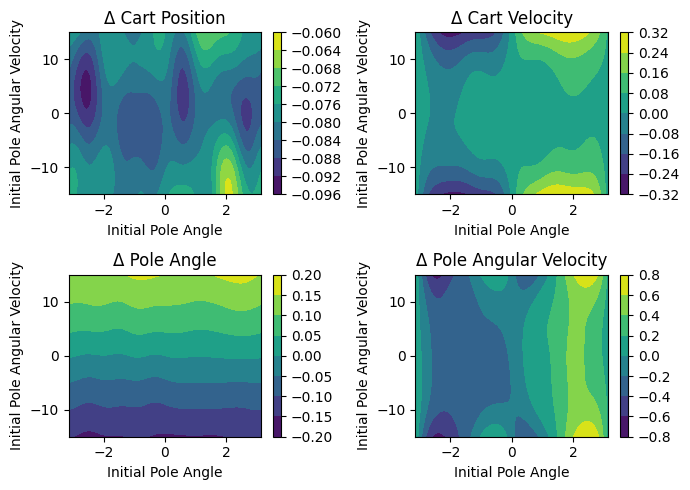

In [26]:
# Create grid of (pole_ang, pole_vel) pairs
PA, PV = np.meshgrid(pole_ang_scan, pole_vel_scan)
PA = PA.ravel()
PV = PV.ravel()

# Build full grid of states with constant cart_pos and cart_vel
X_grid = np.stack([
    np.full_like(PA, cart_pos),
    np.full_like(PA, cart_vel),
    PA,
    PV,
    np.full_like(PA, action),
], axis=1)

# print(X_grid[0])

# construct Kmn matrix: (M, N)
N = X_grid.shape[0]
Kmn = np.zeros((len(kernel_centers), N))

for i, kc in enumerate(kernel_centers):
    Kmn[i] = kernel(X_grid, kc[np.newaxis], sigma=sigma)

# Predict next states using best nonlinear model
deltas = Kmn.T @ best_alphas[best_idx]  # shape: (N, 4)

# Prepare for plotting
X_pred = X_grid[:, 2:4]  # pole angle and velocity
Y_pred = [deltas[:, i] for i in range(len(deltas[0]))]
# print(deltas[0])
# print(Y_pred[0])

# Plotting
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.ravel()

for i in range(len(Y_pred)):
    ax = axes[i]
    tcf = ax.tricontourf(X_pred[:, 0], X_pred[:, 1], Y_pred[i], cmap='viridis')
    ax.set_title(f'Δ {labels[i]}')
    ax.set_xlabel('Initial Pole Angle')
    ax.set_ylabel('Initial Pole Angular Velocity')
    fig.colorbar(tcf, ax=ax)

plt.tight_layout()
plt.show()

In [31]:
# roll outs
env.delta_time = 0.01   # DONT CHANGE: DELTA TIME OF 0.01 USED FOR TRAINING DATA

In [32]:
def plot_colored_phase(ax, x, y, label):
    """
    Plot a colored phase trajectory where color encodes progression
    through the state sequence.
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    idx_norm = np.array([i * env.delta_time for i in range(len(x))])
    lc = matplotlib.collections.LineCollection(segments, array=idx_norm, cmap='viridis', linewidth=0.5)
    ax.add_collection(lc)

    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_xlabel('Cart Velocity')
    ax.set_ylabel('Pole Angular Velocity')
    ax.set_title(label)
    ax.grid(True)
    return lc

In [35]:
# large amplitude
init_state = np.array([0.0, 7, np.pi, 17])
action = 2.0
# init_state = np.array(X_raw[0])
env.setState(init_state)

best_idx = 4
M = num_centers[best_idx]
kernel_centers = X_raw[:M]  # data generated randomly, choose first M points will do
# print(kernel_centers)

num_steps = 500
states = []
states.append(init_state.copy())
pred_states = []
pred_states.append(np.append(init_state.copy(), np.array([action])))

for _ in range(num_steps):
    # true dynamics
    env.performAction(action=action)
    # env.remap_angle()
    states.append(env.getNoisyState().copy())
    
    # prediction
    Kmn = np.zeros((len(kernel_centers), 1))
    for i, kc in enumerate(kernel_centers):
        Kmn[i] = kernel(pred_states[-1][np.newaxis], kc[np.newaxis], sigma=sigma)
    next_pred = Kmn.T @ best_alphas[best_idx] + pred_states[-1][0:4]
    next_pred = np.squeeze(next_pred)
    # print(next_pred)
    # next_pred[2] = CartPole._remap_angle(next_pred[2])
    action = 0.0
    pred_states.append(np.append(next_pred.copy(), np.array([action])))

states = np.array(states)
pred_states = np.array(pred_states)

print(states[0:3])
print(pred_states[0:3])

[[ 0.          7.          3.14159265 17.        ]
 [ 0.04365297  7.06109528  3.35863698 17.1173888 ]
 [ 0.21170763  6.86981217  3.39544308 16.68199259]]
[[ 0.          7.          3.14159265 17.          2.        ]
 [ 0.05312615  7.0378542   3.30730097 17.19754845  0.        ]
 [ 0.1117395   6.94528929  3.47405972 16.98873495  0.        ]]


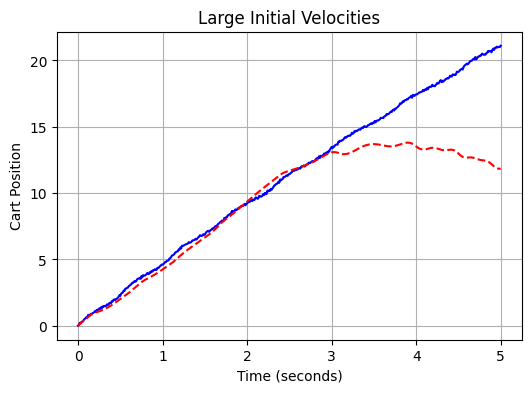

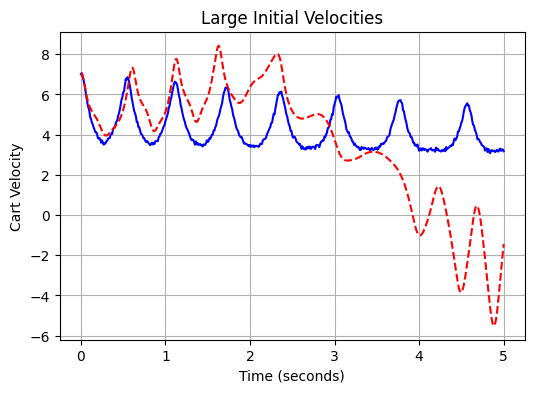

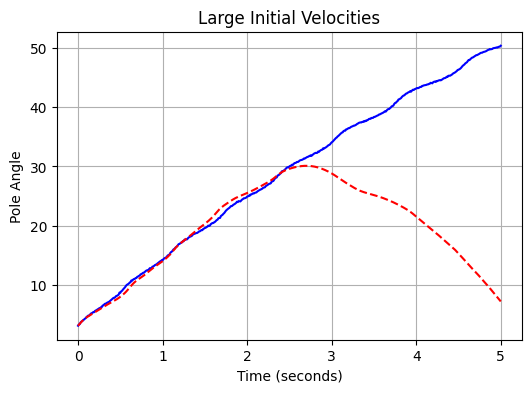

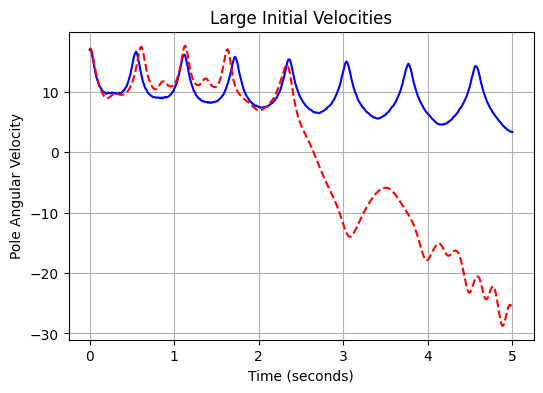

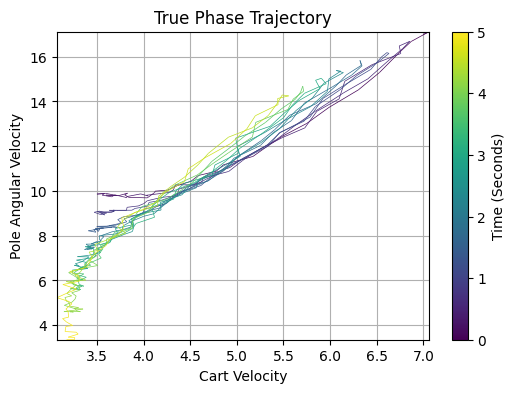

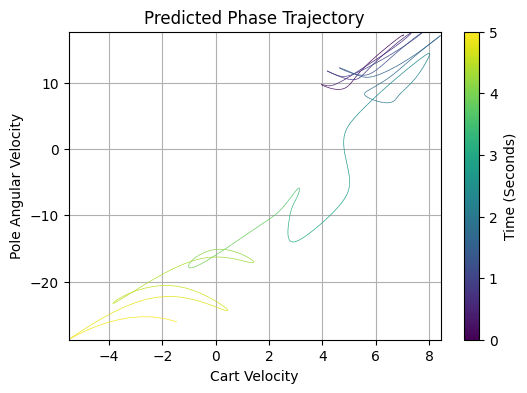

In [36]:
# plot the state trajectory
time = [i * env.delta_time for i in range(num_steps+1)]
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
title = "Large Initial Velocities"


for i in range(len(states[0])):
    plt.figure(figsize=(6, 4))
    plt.plot(time, states[:, i], label='True Evolution', color='blue')
    plt.plot(time, pred_states[:, i], label='Predicted Evolution', color='red', linestyle='--')
    plt.title(title)
    plt.ylabel(labels[i])
    plt.xlabel('Time (seconds)')
    plt.grid(True)
    # plt.savefig(f"1.4_smallosc_{labels[i].replace(' ', '_').lower()}_vs_time.png")

# Plot for True Evolution
fig1, ax1 = plt.subplots(figsize=(6, 4))
lc1 = plot_colored_phase(ax1, states[:, 1], states[:, 3], "True Phase Trajectory")
plt.colorbar(lc1, ax=ax1, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_true.png')

# Plot for Predicted Evolution
fig2, ax2 = plt.subplots(figsize=(6, 4))
lc2 = plot_colored_phase(ax2, pred_states[:, 1], pred_states[:, 3], "Predicted Phase Trajectory")
plt.colorbar(lc2, ax=ax2, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_pred.png')
plt.show()

### Gradient Based Hyperparameter Tuning

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_raw, Y_raw, test_size=0.2, random_state=42)
X_train = jnp.array(X_train)
Y_train = jnp.array(Y_train)
X_val = jnp.array(X_val)
Y_val = jnp.array(Y_val)

In [38]:
def jax_feature_extension(X):
    X = jnp.array(X)

    if X.ndim == 2:
        if X.shape[1] == 5:
            X_sin = jnp.sin(X[:, 2])
            X_cos = jnp.cos(X[:, 2])
            return jnp.column_stack([X[:, 0], X[:, 1], X_sin, X_cos, X[:, 3], X[:, 4]])
        elif X.shape[1] == 6:
            print('feature already extended')
            return X
    elif X.ndim == 1:
        if X.shape[0] == 5:
            return jnp.array([X[0], X[1], jnp.sin(X[2]), jnp.cos(X[2]), X[3], X[4]])
        elif X.shape[0] == 5:
            print('feature already extended')
            return X

    raise ValueError(f'jax_feature_extension FAILED: unexpected input shape {X.shape}')

In [40]:
def jax_kernel(X, Xp, sigma):
    X_ext = jax_feature_extension(X)
    Xp_ext = jax_feature_extension(Xp)

    dist = (X_ext[:, None, :] - Xp_ext[None, :, :]) / sigma
    dist2 = dist ** 2
    return jnp.exp(-0.5 * jnp.sum(dist2, axis=-1))

In [41]:
def jax_loss_fn(hyperparams, X_train, Y_train, X_val, Y_val):
    log_sigma = hyperparams[:-1]
    log_lambda = hyperparams[-1]

    sigma = jnp.exp(log_sigma)
    lmbda = jnp.exp(log_lambda)

    M = 1000
    kernel_centers = X_train[:M]

    Kmn = jax_kernel(X_train, kernel_centers, sigma)
    Kmm = jax_kernel(kernel_centers, kernel_centers, sigma)

    A = Kmn.T @ Kmn + lmbda * Kmm
    b = Kmn.T @ Y_train

    alpha = jnp.linalg.solve(A, b)

    K_val = jax_kernel(X_val, kernel_centers, sigma)
    Y_pred = K_val @ alpha

    # weight error according to variance
    # output_var = Y_train.var(axis=0)
    # weights_jax = 1.0 / output_var
    # mse = jnp.mean(weights_jax * (Y_pred - Y_val) ** 2)
    
    mse = jnp.mean((Y_pred - Y_val) ** 2)
    return mse

In [42]:
jax_loss_grad_fn = jax.jit(jax.value_and_grad(jax_loss_fn))

def scipy_obj(hyperparams_np):
    hyperparams = jnp.array(hyperparams_np)
    loss, grad = jax_loss_grad_fn(hyperparams, X_train, Y_train, X_val, Y_val)
    return float(loss), np.array(grad)

In [43]:
# Initial guess and bounds
X_train_ext = feature_extension(X_train)
init_sigma = jnp.log(jnp.std(X_train_ext, axis=0))        # log sigma
init_lambda = jnp.log(1e-7)                               # log lambda
init_hyperparams = jnp.concatenate([init_sigma, jnp.array([init_lambda])])

bounds = [(jnp.log(1e-3), jnp.log(1e3))] * len(init_sigma) + [(jnp.log(1e-10), jnp.log(1e1))]

In [44]:
# optimization
result = minimize(
    scipy_obj,
    np.array(init_hyperparams),
    method='L-BFGS-B',
    jac=True,
    bounds=bounds,
    options={'disp': True}
)

opt_hyperparams = result.x
final_mse = jax_loss_fn(jnp.array(opt_hyperparams), X_train, Y_train, X_val, Y_val)

print("\n=== Optimization Results ===")
print("Final validation MSE:", final_mse)
print("Optimal sigma:", jnp.exp(opt_hyperparams[:-1]))
print("Optimal lambda:", jnp.exp(opt_hyperparams[-1]))


=== Optimization Results ===
Final validation MSE: 0.0010540719
Optimal sigma: [ 5.5409164  35.735256    0.41932124  0.5661937   6.998435   20.595901  ]
Optimal lambda: 1.00000214e-07


#### Scattered Plot

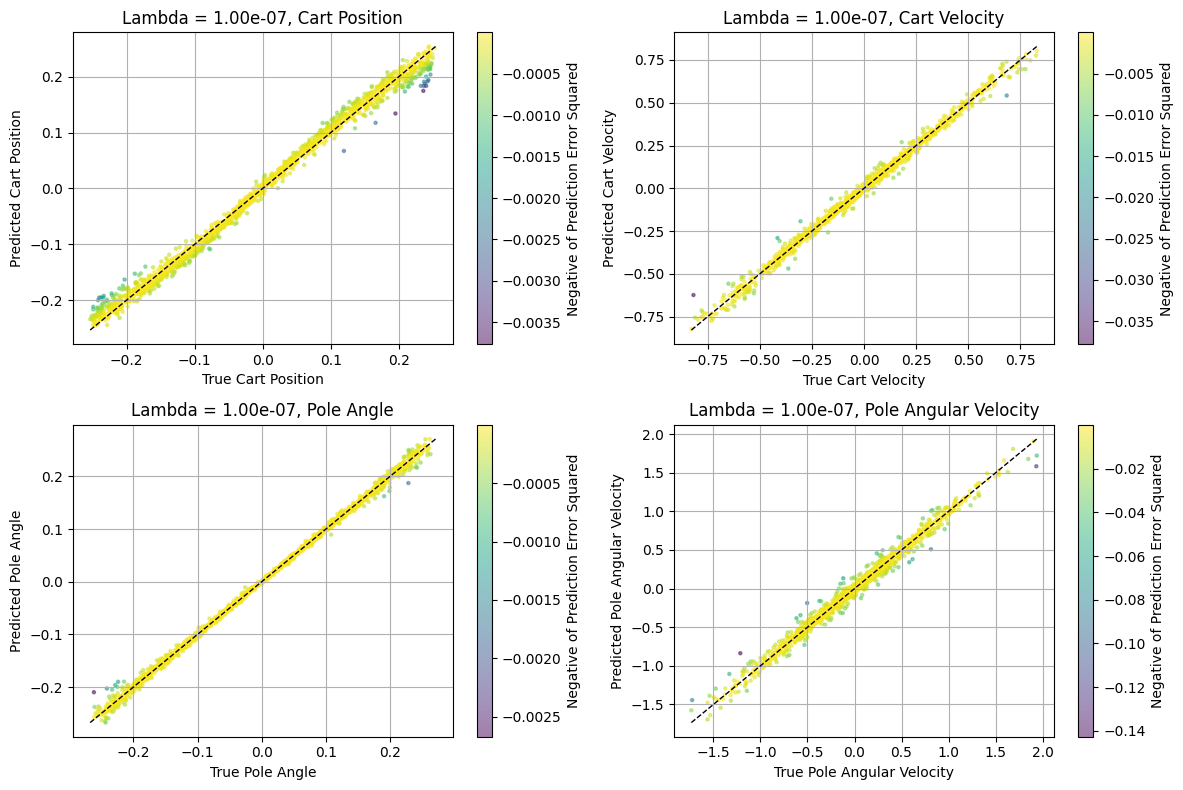

In [50]:
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']

plt.figure(figsize=(12, 8))
for i in range(len(Y_raw[0])):
    true_vals = Y_val[:, i]
    pred_vals = Y_pred[:, i]
    error = -1*(np.abs(pred_vals - true_vals)**2)

    plt.subplot(2, 2, i+1)
    sc = plt.scatter(true_vals, pred_vals, c=error, s=5, cmap='viridis', alpha=0.5)
    
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)
    plt.xlabel('True ' + labels[i])
    plt.ylabel('Predicted ' + labels[i])
    plt.title(f'Lambda = {lambda_opt:.2e}, {labels[i]}')
    plt.grid(True)
    plt.colorbar(sc, label='Negative of Prediction Error Squared')

# plt.savefig('1.3_predict_vs_true.png')
plt.tight_layout()
plt.show()

#### 2D Scan

In [54]:
cart_pos = 0
cart_vel = -7.644
pole_ang = 2.744
pole_vel = 7.176
# [cart_pos, cart_vel, pole_angle, pole_angular_vel]
random_state = [cart_pos, cart_vel, pole_ang, pole_vel]
action = 2.104

In [55]:
# nonlinear model prediction
M = 1000
kernel_centers = X_train[:M]  # data generated randomly, choose first M points will do
# print(kernel_centers)

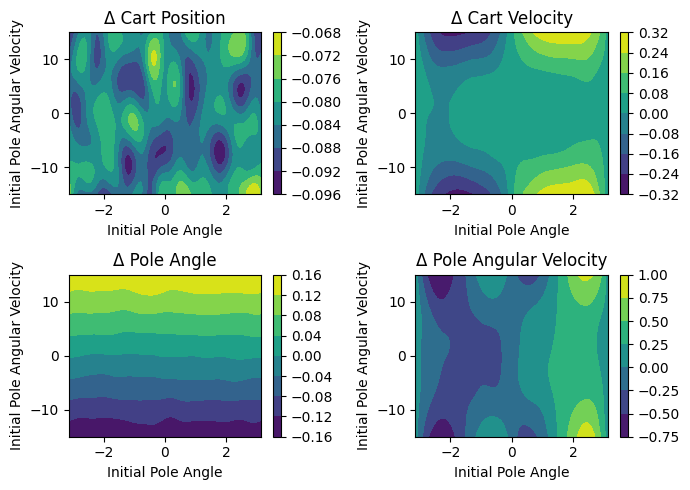

In [57]:
# Create grid of (pole_ang, pole_vel) pairs
PA, PV = np.meshgrid(pole_ang_scan, pole_vel_scan)
PA = PA.ravel()
PV = PV.ravel()

# Build full grid of states with constant cart_pos and cart_vel
X_grid = np.stack([
    np.full_like(PA, cart_pos),
    np.full_like(PA, cart_vel),
    PA,
    PV,
    np.full_like(PA, action)
], axis=1)

# print(X_grid[0])


# construct Kmn matrix: (M, N)
N = X_grid.shape[0]
Kmn = np.zeros((len(kernel_centers), N))

for i, kc in enumerate(kernel_centers):
    Kmn[i] = kernel(X_grid, kc[np.newaxis], sigma=sigma_opt)

# Predict next states using best nonlinear model
deltas = Kmn.T @ alpha_opt  # shape: (N, 4)

# Prepare for plotting
X_pred = X_grid[:, 2:4]  # pole angle and velocity
Y_pred = [deltas[:, i] for i in range(len(deltas[0]))]

# Plotting
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.ravel()

for i in range(len(Y_pred)):
    ax = axes[i]
    tcf = ax.tricontourf(X_pred[:, 0], X_pred[:, 1], Y_pred[i], cmap='viridis')
    ax.set_title(f'Δ {labels[i]}')
    ax.set_xlabel('Initial Pole Angle')
    ax.set_ylabel('Initial Pole Angular Velocity')
    fig.colorbar(tcf, ax=ax)

plt.tight_layout()
plt.savefig('4.1_2D_noisy_model.png')
plt.show()

#### Rollout

In [74]:
# random initial state

init_state = np.array([-1.66872672, -3.19136526,  2.50744151, -8.45156454])
action = 2.0
env.setState(init_state)
init_state_act = np.append(init_state.copy(), np.array([action]))
print(f'initial state: {init_state_act}')

M = 1000
N = len(X_train)
kernel_centers = X_train[:M]

sigma_opt = np.array(jnp.exp(opt_hyperparams[:-1]))
lambda_opt = np.array(jnp.exp(opt_hyperparams[-1]))

# construct Kmn matrix
Kmn = np.zeros((M, N))
for i, kernel_center in enumerate(kernel_centers):
    Kmn[i] = kernel(X_train, kernel_center[np.newaxis], sigma=sigma_opt)  # newaxis reshapes kernel_center

Kmm = np.zeros((M, M))
for i, kernel_center in enumerate(kernel_centers):
    Kmm[i] = kernel(kernel_centers, kernel_center[np.newaxis], sigma=sigma_opt)

# least square fit
A = Kmn @ Kmn.T + lambda_opt * Kmm
b = Kmn @ Y_train
alpha_opt = np.linalg.lstsq(A, b, rcond=None)[0]

# print(kernel_centers)
# print(alpha_opt)

num_steps = 1000
states = []
states.append(init_state.copy())
pred_states = []
pred_states.append(np.append(init_state.copy(), np.array([action])))

for i in range(num_steps):
    if i % 50 == 0:
        print(i)
    # true dynamics
    env.performAction(action=action)
    # env.remap_angle()
    states.append(env.getState().copy())
    
    # prediction
    Kmn = np.zeros((len(kernel_centers), 1))
    for i, kc in enumerate(kernel_centers):
        Kmn[i] = kernel(pred_states[-1][np.newaxis], kc[np.newaxis], sigma=sigma_opt)
    next_pred = Kmn.T @ alpha_opt + pred_states[-1][0:4]
    next_pred = np.squeeze(next_pred)
    # print(next_pred)
    # next_pred[2] = CartPole._remap_angle(next_pred[2])
    action = 0.0
    pred_states.append(np.append(next_pred.copy(), np.array([action])))

states = np.array(states)
pred_states = np.array(pred_states)

initial state: [-1.66872672 -3.19136526  2.50744151 -8.45156454  2.        ]
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


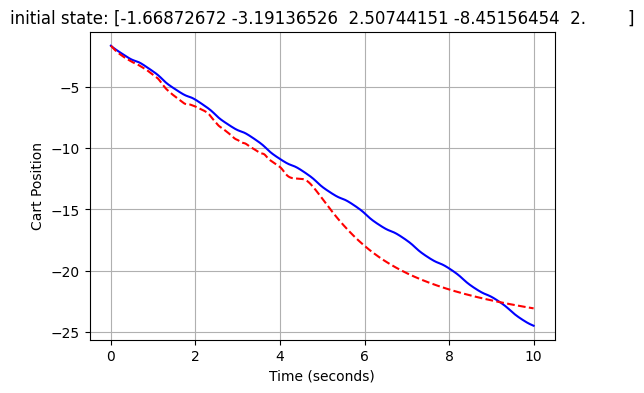

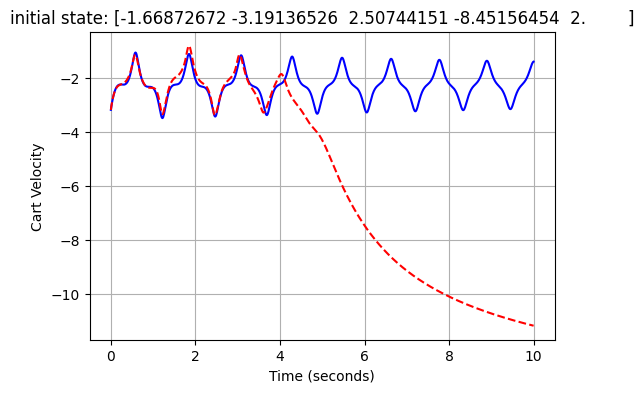

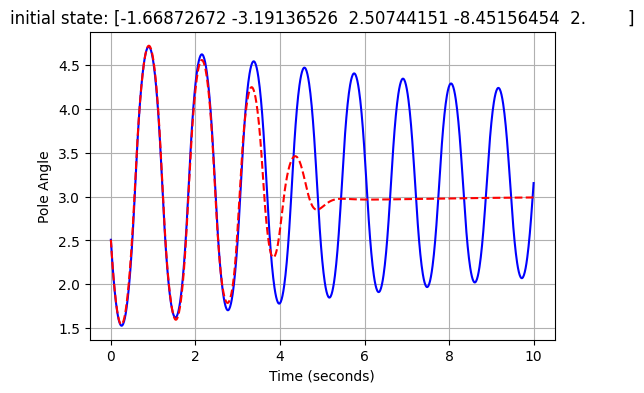

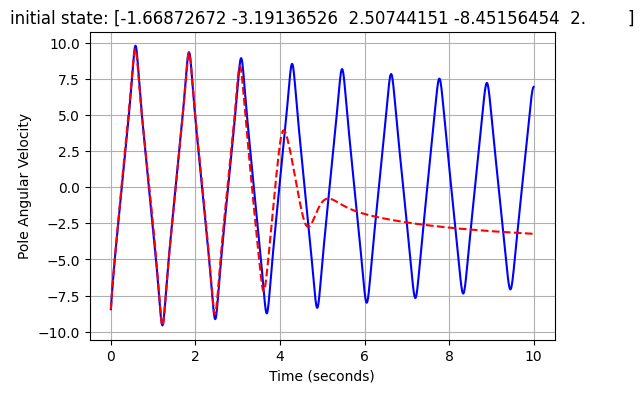

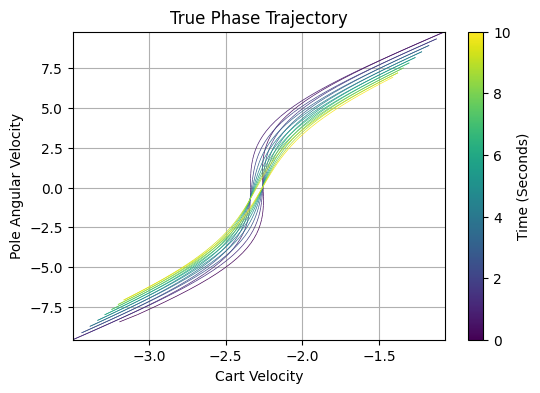

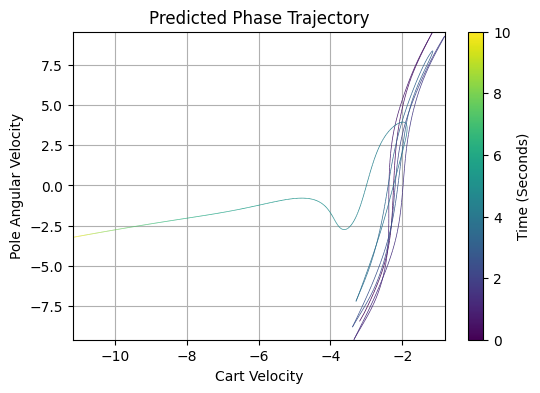

In [75]:
# plot the state trajectory
time = [i * env.delta_time for i in range(num_steps+1)]
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
title = f'initial state: {init_state_act}'


for i in range(len(states[0])):
    plt.figure(figsize=(6, 4))
    plt.plot(time, states[:, i], label='True Evolution', color='blue')
    plt.plot(time, pred_states[:, i], label='Predicted Evolution', color='red', linestyle='--')
    plt.title(title)
    plt.ylabel(labels[i])
    plt.xlabel('Time (seconds)')
    plt.grid(True)
    # plt.savefig(f"1.4_smallosc_{labels[i].replace(' ', '_').lower()}_vs_time.png")

# Plot for True Evolution
fig1, ax1 = plt.subplots(figsize=(6, 4))
lc1 = plot_colored_phase(ax1, states[:, 1], states[:, 3], "True Phase Trajectory")
plt.colorbar(lc1, ax=ax1, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_true.png')

# Plot for Predicted Evolution
fig2, ax2 = plt.subplots(figsize=(6, 4))
lc2 = plot_colored_phase(ax2, pred_states[:, 1], pred_states[:, 3], "Predicted Phase Trajectory")
plt.colorbar(lc2, ax=ax2, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_pred.png')
plt.show()

## Linear Model

In [76]:
X_raw = np.load('X_dt0p010_N8000_act_notanh_obsnoise.npy')
Y_raw = np.load('Y_dt0p010_N8000_act_notanh_obsnoise.npy')
X_ext = feature_extension(X_raw)
print(X_ext[0])

C_T, _, _, _ = np.linalg.lstsq(X_ext, Y_raw, rcond=None)
C = C_T.T
print(C[0])

[ -4.60134735 -17.60932216   0.72780163  -0.68578771 -22.7409456
   0.2258428 ]
[ 3.66951160e-06  9.99982238e-03  2.91314572e-03 -5.16843591e-06
 -1.01228526e-06  1.29988292e-04]


#### Scattered Plot

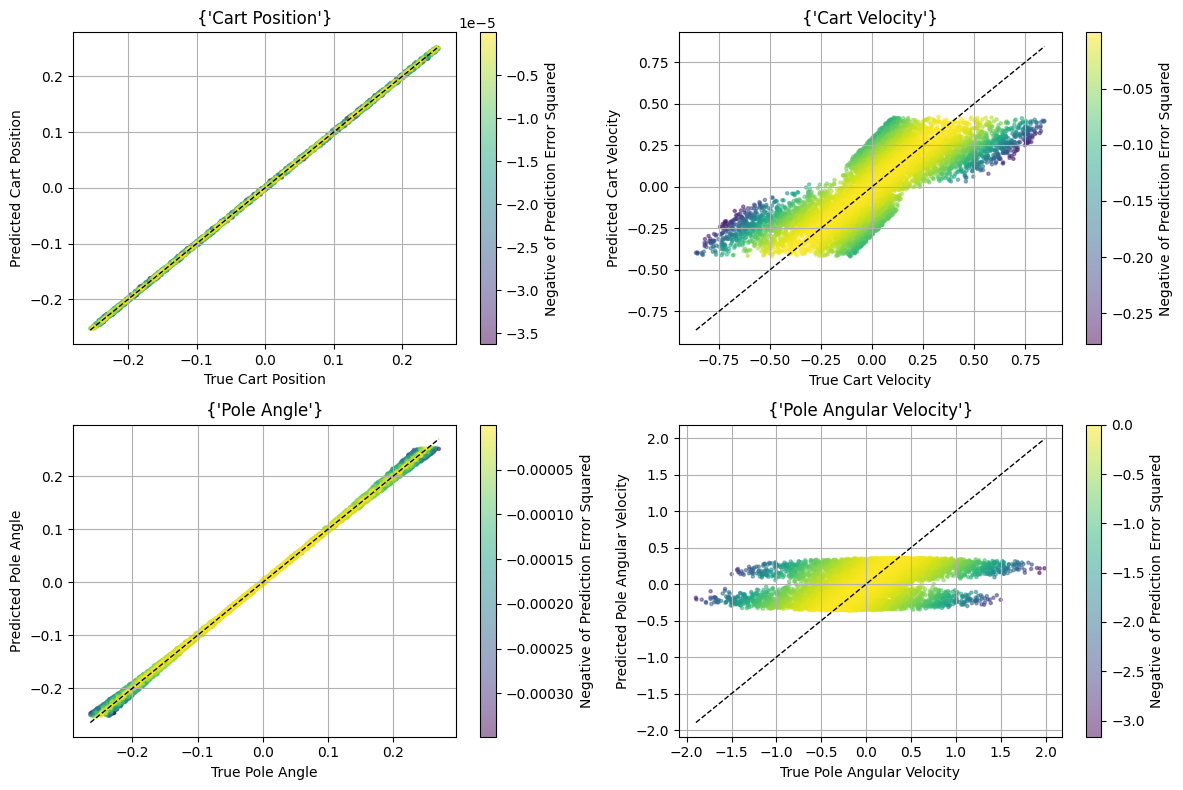

In [77]:
Y_pred = X_ext @ C_T

labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']

plt.figure(figsize=(12, 8))
for i in range(len(Y_raw[0])):
    true_vals = Y_raw[:, i]
    pred_vals = Y_pred[:, i]
    error = -1*(np.abs(pred_vals - true_vals)**2)

    plt.subplot(2, 2, i+1)
    sc = plt.scatter(true_vals, pred_vals, c=error, s=5, cmap='viridis', alpha=0.5)
    
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())
    # y = x line
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)
    plt.xlabel('True ' + labels[i])
    plt.ylabel('Predicted ' + labels[i])
    plt.title({labels[i]})
    plt.grid(True)
    plt.colorbar(sc, label='Negative of Prediction Error Squared')

# plt.savefig('1.3_predict_vs_true.png')
plt.tight_layout()
plt.show()

#### Rollout

In [80]:
# random initial state
init_state = np.array([-1.66872672, -3.19136526,  2.50744151, -8.45156454])
action = 2.0
env.setState(init_state)
init_state_act = np.append(init_state.copy(), np.array([action]))
print(f'initial state: {init_state_act}')

num_steps = 500
states = []
states.append(init_state.copy())
pred_states = []
pred_states.append(np.append(init_state.copy(), np.array([action])))

for _ in range(num_steps):
    env.performAction(action=action)
    # env.remap_angle()
    states.append(env.getState().copy())
    
    next_pred = feature_extension(pred_states[-1]) @ C_T + pred_states[-1][0:4]
    # next_pred[2] = CartPole._remap_angle(next_pred[2])
    action = 0.0
    pred_states.append(np.append(next_pred.copy(), np.array([action])))

states = np.array(states)
pred_states = np.array(pred_states)

print(states[0:3])
print(pred_states[0:3])

initial state: [-1.66872672 -3.19136526  2.50744151 -8.45156454  2.        ]
[[-1.66872672 -3.19136526  2.50744151 -8.45156454]
 [-1.69944282 -3.07161005  2.42758223 -7.98592756]
 [-1.72926043 -2.98176096  2.35170452 -7.58777111]]
[[-1.66872672 -3.19136526  2.50744151 -8.45156454  2.        ]
 [-1.69864721 -2.9924692   2.42501159 -8.24351384  0.        ]
 [-1.72665198 -2.80058623  2.34486878 -8.01478845  0.        ]]


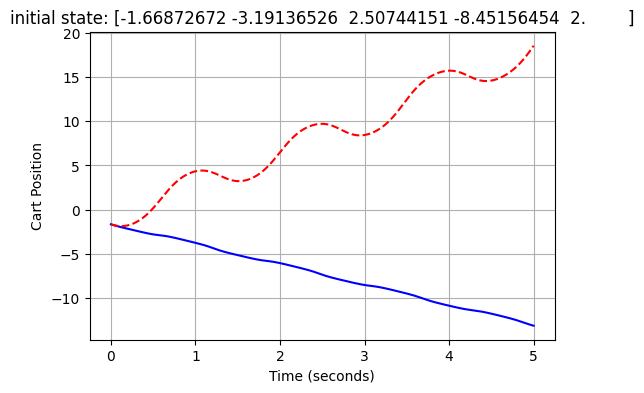

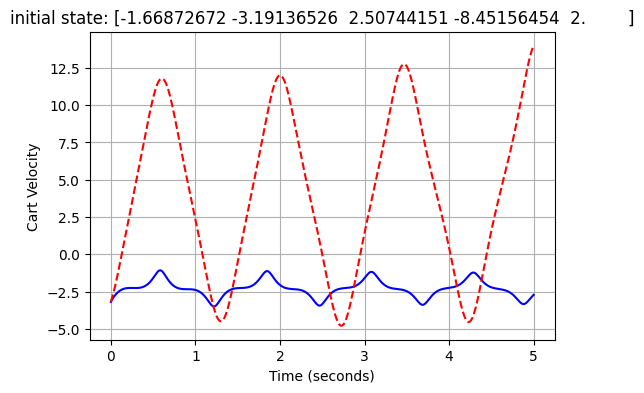

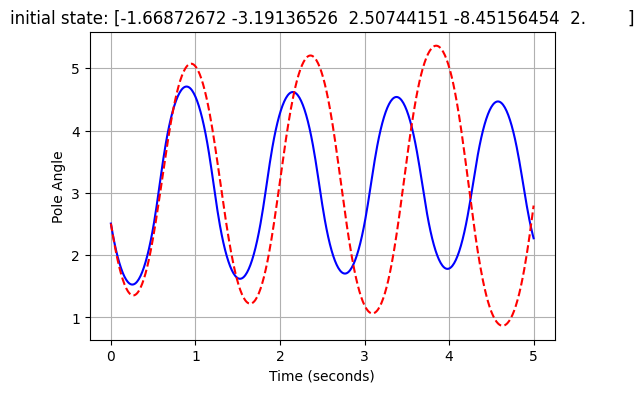

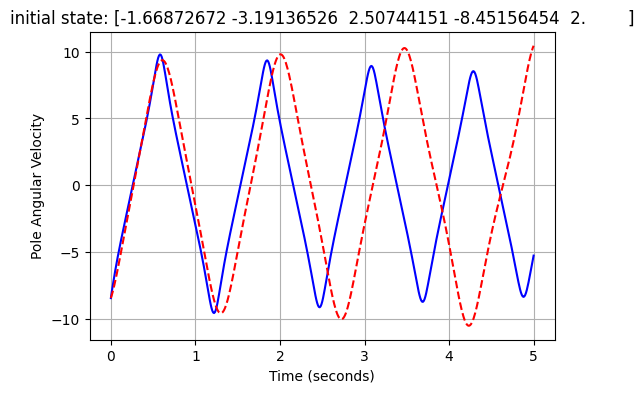

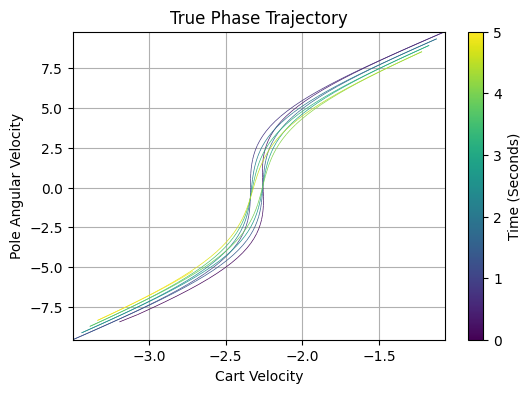

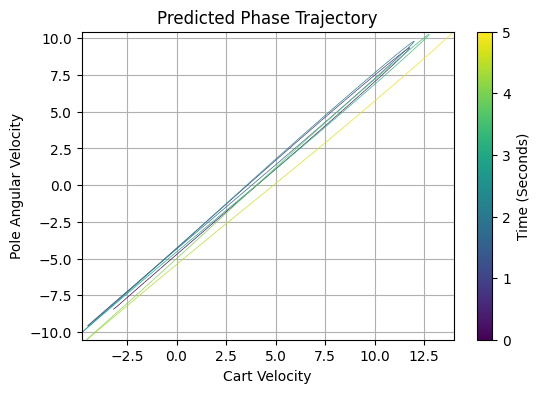

In [81]:
# plot the state trajectory
time = [i * env.delta_time for i in range(num_steps+1)]
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
title = f'initial state: {init_state_act}'


for i in range(4):
    plt.figure(figsize=(6, 4))
    plt.plot(time, states[:, i], label='True Evolution', color='blue')
    plt.plot(time, pred_states[:, i], label='Predicted Evolution', color='red', linestyle='--')
    plt.title(title)
    plt.ylabel(labels[i])
    plt.xlabel('Time (seconds)')
    plt.grid(True)
    # plt.savefig(f"1.4_smallosc_{labels[i].replace(' ', '_').lower()}_vs_time.png")

# Plot for True Evolution
fig1, ax1 = plt.subplots(figsize=(6, 4))
lc1 = plot_colored_phase(ax1, states[:, 1], states[:, 3], "True Phase Trajectory")
plt.colorbar(lc1, ax=ax1, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_true.png')

# Plot for Predicted Evolution
fig2, ax2 = plt.subplots(figsize=(6, 4))
lc2 = plot_colored_phase(ax2, pred_states[:, 1], pred_states[:, 3], "Predicted Phase Trajectory")
plt.colorbar(lc2, ax=ax2, label='Time (Seconds)')
# plt.savefig('1.4_large_contour_pred.png')
plt.show()